### Data exploration before image-preparation

In [1]:
from scripts.data_exploration import *

# as we have two wrong files: 
# 55_0_0_20170116232725357JPG
# 44_1_4_20170116235150272.pg
file_endings = print_file_endings()

folder_names = ['data/part1', 'data/part2', 'data/part3']
df = get_dataframe(folder_names)
create_csv(df, "unprepared_images.csv")
# show_all_plots(df) # TODO: uncomment to view data
print_statistics(df)

Number of JPG files: 24106
Number of DS_STORE files: 1
Number of PG files: 1
Number of 55_0_0_20170116232725357JPG files: 1
count    24101.000000
mean        33.042156
std         20.139284
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: Age, dtype: float64

Gender Distribution:
	male: 12580 (52.20%)
	female: 11521 (47.80%)

Race Distribution:
	White: 10221 (42.41%)
	Black: 4557 (18.91%)
	Indian: 4027 (16.71%)
	Asian: 3586 (14.88%)
	Others: 1710 (7.10%)


### Image preparation

In [2]:
from scripts.image_helper_functions import *

# this will take some time
# TODO: uncomment this to crop all images, if not already done
# crop_all_images_multi_threaded()

### Data exploration after image preparation

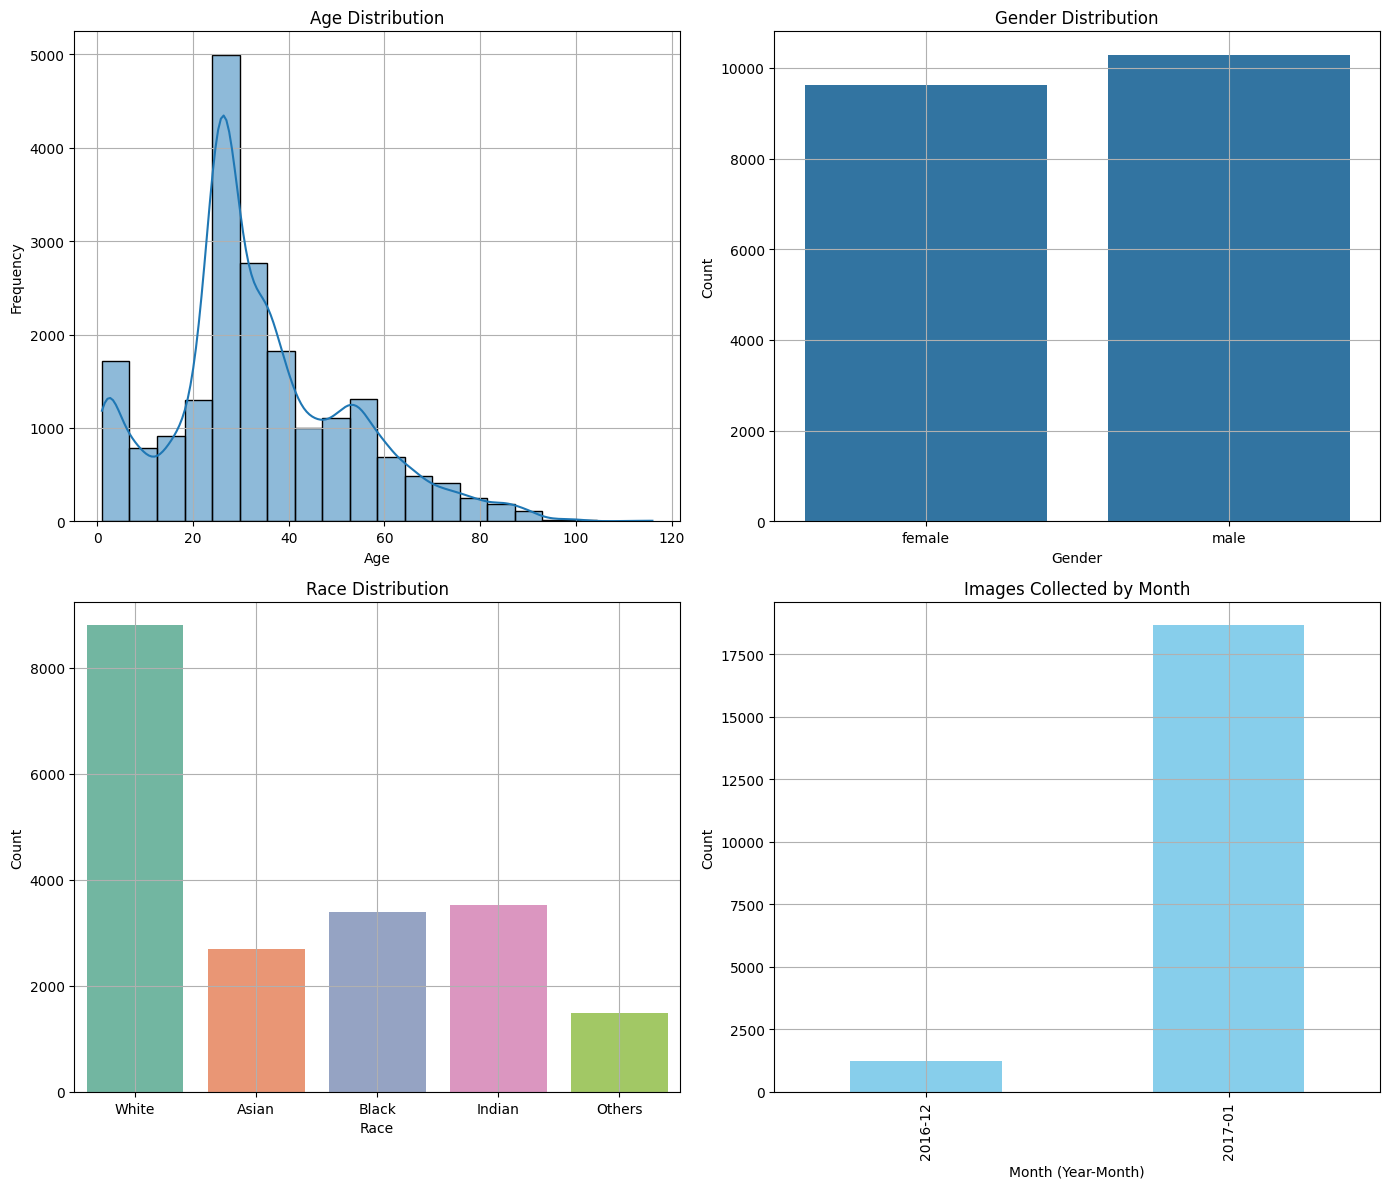

count    19905.000000
mean        33.739714
std         19.047839
min          1.000000
25%         24.000000
50%         30.000000
75%         45.000000
max        116.000000
Name: Age, dtype: float64

Gender Distribution:
	male: 10290 (51.70%)
	female: 9615 (48.30%)

Race Distribution:
	White: 8804 (44.23%)
	Indian: 3526 (17.71%)
	Black: 3388 (17.02%)
	Asian: 2693 (13.53%)
	Others: 1494 (7.51%)


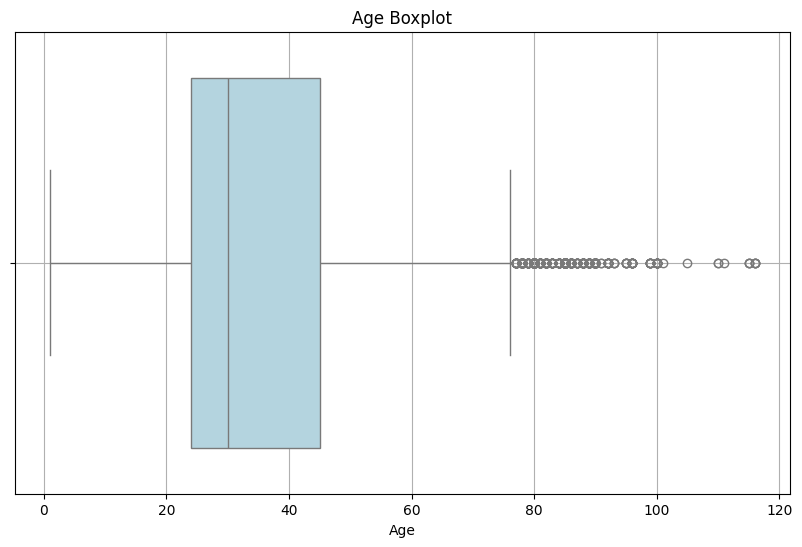

In [3]:
folder_names = ['data/part1_prepared', 'data/part2_prepared', 'data/part3_prepared']
df_prepared = get_dataframe(folder_names)
create_csv(df_prepared, "prepared_images.csv")
show_all_plots(df_prepared) # TODO: uncomment to view data
print_statistics(df_prepared)

### Data augmentation

In [4]:
from scripts.data_augmentation import *

ageList = ['(0-4)', '(5-14)', '(15-24)', '(25-34)', '(35-49)', '(50-69)', '(70-117)']
age_bins = [0, 4, 14, 24, 34, 49, 69, 117]  # Age bin edges

df_prepared['age_bin'] = pd.cut(df_prepared['Age'], bins=age_bins, labels=ageList, right=False)

print("Columns in df_prepared:", df_prepared.columns.tolist())

# Perform data augmentation to balance the dataset
augmented_data_dir = 'data/augmented_images'
augment_data(df_prepared, 'age_bin', augmented_data_dir)

# Update the DataFrame with augmented data
df_augmented = get_augmented_data(augmented_data_dir, 'age_bin')
df_combined = pd.concat([df_prepared, df_augmented], ignore_index=True)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)



Columns in df_prepared: ['Unique-Identifier', 'Age', 'Gender', 'Race', 'DateTime', 'Month', 'age_bin']


Augmenting images: 100%|██████████| 1239/1239 [00:27<00:00, 45.47it/s]


No additional images needed.


Augmenting images: 100%|██████████| 3250/3250 [00:53<00:00, 60.34it/s]


### Model building

In [ ]:
from scripts.image_helper_functions import *

# THIS IS CURRENTLY ONLY FOR TESTING - WILL BE CLEANED UP

test_image = get_image_from_path('scripts/test.jpg')
grey_image = get_gray_image(test_image)
resized_grey_image = resize_by_height(grey_image, 400)
display_image(resized_grey_image, 'grey and resized image')

# Model requirements for image
ageList = ['(0-4)', '(5-14)', '(15-24)', '(25-34)', '(35-49)', '(50-69)', '(70-100)']
age_bins = [0, 4, 14, 24, 34, 49, 69, 100]  # Age bin edges

# ------------ Model for Age detection ------------ #
# Define the CNN model
def create_cnn_model(input_shape=(200, 200, 1), num_classes=len(ageList)):    #change for resized image size
    model = models.Sequential()
    # Input layer with 32 filters, followed by an AveragePooling2D layer
    model.add(layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.AveragePooling2D((2, 2)))
    # Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer
    model.add(layers.Conv2D(64, kernel_size=3, activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(128, kernel_size=3, activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(256, kernel_size=3, activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))
    # A GlobalAveragePooling2D layer before going into Dense layers below
    # GlobalAveragePooling2D layer limits outputs to number of filters in last Conv2D layer above (256)
    model.add(layers.GlobalAveragePooling2D())      
    #model.add(layers.Flatten())    #should not be needed
    model.add(layers.Dense(132, activation='relu')) # Reduces layers to 132 before final output
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


framed_image = get_framed_cropped_face_image(resized_grey_image)
display_image(framed_image, 'framed and cropped image')
# ----- Image preprocessing --------#

# -------Age Prediction---------#
